In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
import selfies as sf
import matplotlib.pyplot as plt
import matplotlib

In [2]:
class CONFIGS:
    def __init__(self):
        self.NUM_IDX = 5

        self.INPUT_DIR = 'outputs_1_evaluate_property_similarity_scores'
        self.OUTPUT_DIR = 'outputs_2_draw_success_rate_over_edit_iterations'
        if not os.path.exists(self.OUTPUT_DIR):
            os.mkdir(self.OUTPUT_DIR)
    
configs = CONFIGS()

## Generated molecules

In [3]:
def read_frames(configs, DATA_TYPE):
    frames = []
    for i in tqdm.trange(configs.NUM_IDX):
        filepath_generated = os.path.join(configs.INPUT_DIR, DATA_TYPE, f'generated_edit_iter{i+1}.csv')
        df = pd.read_csv(filepath_generated)
        frames.append(df)
    return frames

In [4]:
frames_qed = read_frames(configs, 'qed')
frames_drd2 = read_frames(configs, 'drd2')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


In [5]:
eval_config = {
    'qed':{'low_bound':0.9, 'sim':0.4, 'k_num':20},
    'drd2':{'low_bound':0.5, 'sim':0.4, 'k_num':20},
}

In [6]:
def calculate_success(eval_config, df_opt):
    df = df_opt.copy()
    
    assert len(df) == len(df.drop_duplicates(subset=('SMILES_ori',))) * eval_config['k_num']
    
    df.loc[:,'QUALIFIED_PROP'] = df.loc[:,'PROPERTY_opt'] > eval_config['low_bound'] - 1e-8
    df.loc[:,'QUALIFIED_SIM'] = df.loc[:,'SIMILARITY_ori_opt'] > eval_config['sim'] - 1e-8
    df.loc[:,'QUALIFIED'] = df.loc[:,'QUALIFIED_PROP'] & df.loc[:,'QUALIFIED_SIM']
    
    df = df.loc[:,('SMILES_ori', 'QUALIFIED')].groupby(by='SMILES_ori').sum().reset_index(drop=True)
    
    return (df.loc[:,'QUALIFIED'] > 0).mean()

In [7]:
success_rates_qed = [calculate_success(eval_config['qed'], df) for df in frames_qed]
success_rates_drd2 = [calculate_success(eval_config['drd2'], df) for df in frames_drd2]

# Draw plot

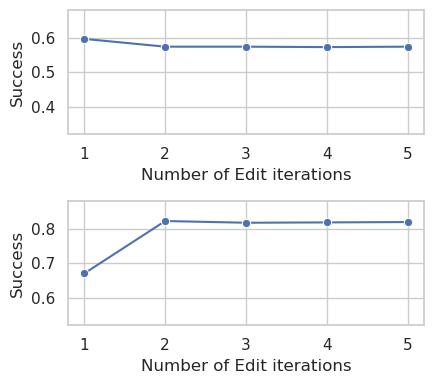

In [53]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(2,1,figsize=(4.5,4))

assert len(success_rates_qed) == len(success_rates_drd2)
pos = range(1, len(success_rates_qed)+1)

_ = sns.lineplot(
    x=pos,
    y=success_rates_qed,
    marker='o',
    ax=ax[0],
)

_ = sns.lineplot(
    x=pos,
    y=success_rates_drd2,
    marker='o',
    ax=ax[1],
)

#ylim = [(0.571, 0.599),
ylim = [(0.32, 0.68),
        (0.52, 0.88)]

for i in range(2):
    ax[i].set_xticks(pos)
    ax[i].set_xlabel('Number of Edit iterations')
    ax[i].set_ylabel('Success')
    ax[i].set_ylim(*ylim[i])

plt.tight_layout()
#plt.show()
plt.savefig(os.path.join(configs.OUTPUT_DIR, 'lineplots_qed_drd2.png'), dpi=300)